## ConvNet

## Load packages

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Load data

In [3]:
# Set up dictionary for CSV files
csv_files = dict()

# Load files into dictionary
filenames = os.listdir('./data_csv')
for file in filenames:
    filename, file_extension = os.path.splitext(f'./data_csv/{file}')
    # Remove path from filenmaes and load data
    if file_extension == '.csv':
        filename_short = filename.split('/')[-1]
        csv_files[filename_short] = pd.read_csv(f'./data_csv/{file}')

# Load meta data and transform
metadata = pd.read_csv('./data_csv/metadata.csv', index_col='parameter')
csv_index = list(metadata)

In [4]:
csv_files[csv_index[0]]

,seconds,FHR,UC
0,0,128.50,21.5
1,1,128.00,21.5
2,2,128.00,21.5
3,3,127.25,21.5
4,4,127.25,21.0
...,...,...,...
17995,17995,126.00,10.5
17996,17996,126.00,10.5
17997,17997,126.25,10.5
17998,17998,126.25,10.5


In [5]:
test_completion = np.arange(50, 96, 5)
completion_dict = dict()
for completion in test_completion:
    completion_dict[completion] = []

for index in csv_index:
    df = csv_files[index]
    fhr_complete = np.mean(df['FHR'] > 0)
    for complete in test_completion:
        if fhr_complete * 100 >= complete:
            completion_dict[complete].append(index)

Show number of records meeting compoletion targets.

In [6]:
for complete in test_completion:
    print (f'{complete}% complete: {len(completion_dict[complete])}')

50% complete: 547
55% complete: 534
60% complete: 521
65% complete: 499
70% complete: 447
75% complete: 389
80% complete: 300
85% complete: 229
90% complete: 152
95% complete: 94


In [7]:
fhr = []
# Get FHR records for 70% complete and store as NumPy
for file in completion_dict[50]:
    csv = pd.read_csv(f'./data_csv/{file}.csv')
    fhr_data = csv['FHR'].values
    fhr.append(fhr_data)

In [8]:
# Remove zeros
clean_fhr = []

for f in fhr:
    mask = f > 0
    clean_fhr.append(f[mask])

In [9]:
# Truncate to shortest length
min_length = min([len(x) for x in clean_fhr])

clean_fhr_truncated = []
for f in clean_fhr:
    clean_fhr_truncated.append(f[-min_length:])

In [10]:
clean_fhr = np.stack(clean_fhr_truncated)

In [11]:
metadata = metadata[completion_dict[50]]

(array([  0.,   1.,   6.,  11.,  20.,  15.,  49.,  72.,  94., 120.,  99.,
         49.,   9.,   2.]),
 array([6.8 , 6.85, 6.9 , 6.95, 7.  , 7.05, 7.1 , 7.15, 7.2 , 7.25, 7.3 ,
        7.35, 7.4 , 7.45, 7.5 ]),
 <BarContainer object of 14 artists>)

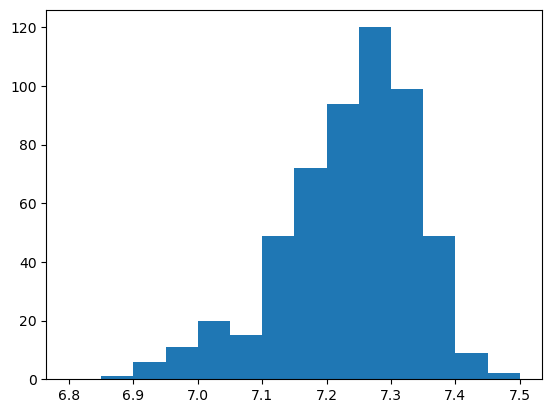

In [12]:
plt.hist(metadata.loc['pH'], bins=np.arange(6.8, 7.5, 0.05))

In [13]:
X = clean_fhr
y = metadata.loc['pH'] <7.2
y = y.values

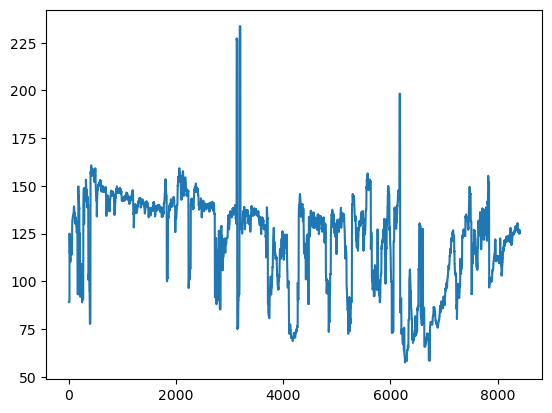

In [14]:
plt.plot(X[0])

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# Truncate to last 30 mins
X = X[:, -30*60:]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state=42)

In [18]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

In [19]:
# Scale X data
X_train_sc, X_test_sc = scale_data(X_train, X_test)

X_train_sc = X_train_sc.reshape((X_train_sc.shape[0], X_train_sc.shape[1], 1))
X_test_sc = X_test_sc.reshape((X_test_sc.shape[0], X_test_sc.shape[1], 1))

n_classes = len(np.unique(y_train))

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

2023-10-12 10:18:30.548242: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-12 10:18:30.928557: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-12 10:18:30.928621: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-12 10:18:30.930687: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-12 10:18:31.072787: I tensorflow/core/platform/cpu_feature_g

2023-10-12 10:18:35.852117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-12 10:18:35.892545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-12 10:18:35.892994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

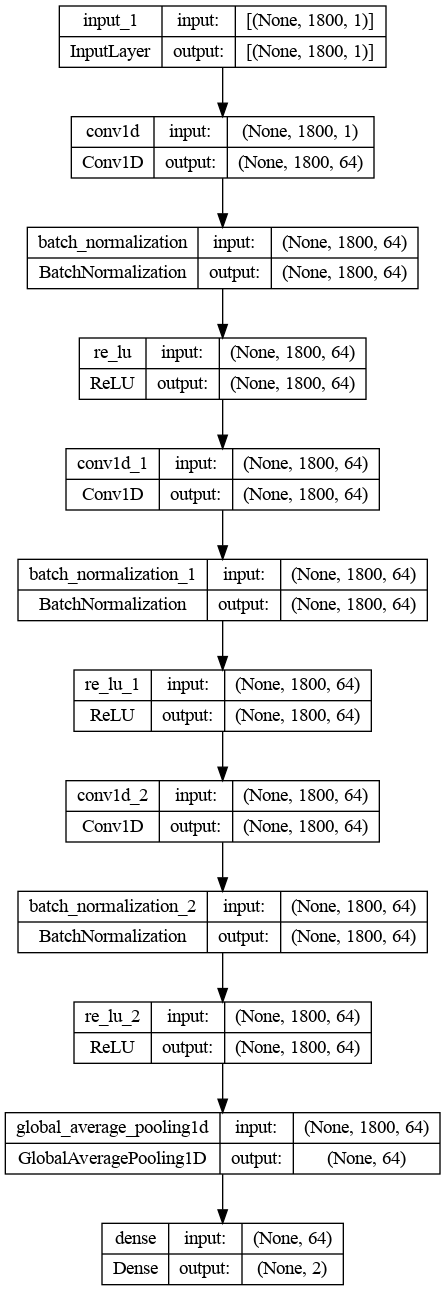

In [21]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    #conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    #conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    #conv3 = keras.layers.MaxPooling1D(pool_size=2)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(n_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=X_train_sc.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [22]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train_sc,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500


2023-10-12 10:18:42.578133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-12 10:18:46.272515: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3743725f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-12 10:18:46.272557: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-10-12 10:18:46.285969: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-12 10:18:46.448726: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 [==============================] - 12s 120ms/step - loss: 0.5870 - sparse_categorical_accuracy: 0.6890 - val_loss: 0.6758 - val_sparse_categorical_accuracy: 0.6585 - lr: 0.0010
Epoch 2/500
 4/11 [=========>....................] - ETA: 0s - loss: 0.4857 - sparse_categorical_accuracy: 0.7812

/home/amy/miniconda3/envs/ctg/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 0s 32ms/step - loss: 0.5752 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.6576 - val_sparse_categorical_accuracy: 0.6585 - lr: 0.0010
Epoch 3/500
11/11 [==============================] - 0s 35ms/step - loss: 0.5615 - sparse_categorical_accuracy: 0.7409 - val_loss: 0.6444 - val_sparse_categorical_accuracy: 0.6585 - lr: 0.0010
Epoch 4/500
11/11 [==============================] - 0s 33ms/step - loss: 0.5647 - sparse_categorical_accuracy: 0.7378 - val_loss: 0.6364 - val_sparse_categorical_accuracy: 0.6585 - lr: 0.0010
Epoch 5/500
11/11 [==============================] - 0s 36ms/step - loss: 0.5570 - sparse_categorical_accuracy: 0.7470 - val_loss: 0.6355 - val_sparse_categorical_accuracy: 0.6585 - lr: 0.0010
Epoch 6/500
11/11 [==============================] - 0s 28ms/step - loss: 0.5652 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.6384 - val_sparse_categorical_accuracy: 0.6585 - lr: 0.0010
Epoch 7/500
11/11 [============================

In [23]:
y_pred = model.predict(X_test_sc)[:,1]

5/5 [==============================] - 0s 34ms/step


In [24]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print (f'AUC {roc_auc:0.4f}')

AUC 0.5839


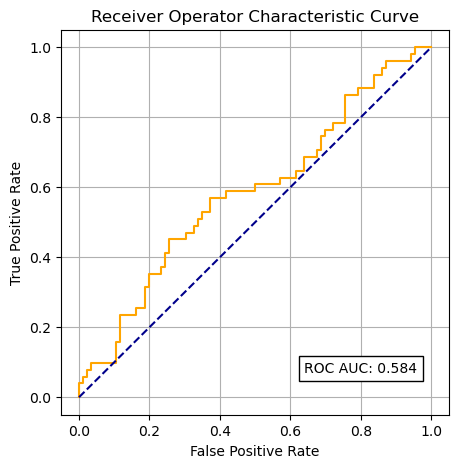

In [25]:
fig = plt.figure(figsize=(5,5))

# Plot ROC
ax1 = fig.add_subplot(111)
ax1.plot(fpr, tpr, color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'ROC AUC: {roc_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)
plt.show()

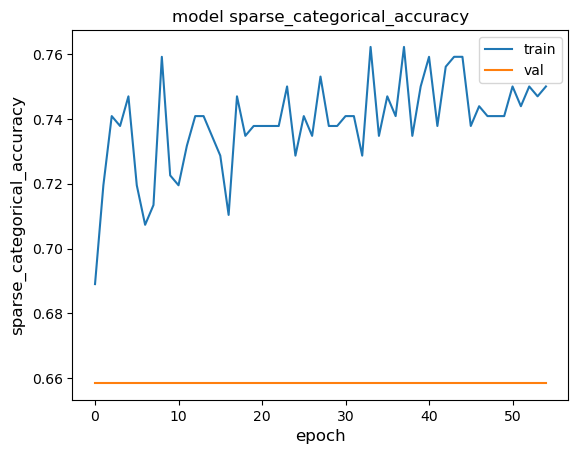

In [26]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()